# Оптимизация с помощью гауссовских процессов

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Введение" data-toc-modified-id="Введение-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Введение</a></span><ul class="toc-item"><li><span><a href="#Surrogate-model" data-toc-modified-id="Surrogate-model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Surrogate model</a></span></li><li><span><a href="#Суррогатная-модель" data-toc-modified-id="Суррогатная-модель-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Суррогатная модель</a></span></li><li><span><a href="#Acquisition-functions" data-toc-modified-id="Acquisition-functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Acquisition functions</a></span></li><li><span><a href="#Функции-приобретения" data-toc-modified-id="Функции-приобретения-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Функции приобретения</a></span></li><li><span><a href="#Алгоритм-оптимизации" data-toc-modified-id="Алгоритм-оптимизации-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Алгоритм оптимизации</a></span></li><li><span><a href="#Ожидаемое-улучшение-(Expected-improvement,-EI)" data-toc-modified-id="Ожидаемое-улучшение-(Expected-improvement,-EI)-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Ожидаемое улучшение (Expected improvement, EI)</a></span></li></ul></li><li><span><a href="#Implementation-with-NumPy-and-SciPy" data-toc-modified-id="Implementation-with-NumPy-and-SciPy-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Implementation with NumPy and SciPy</a></span></li><li><span><a href="#Реализация-с-NumPy-и-SciPy." data-toc-modified-id="Реализация-с-NumPy-и-SciPy.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Реализация с NumPy и SciPy.</a></span></li><li><span><a href="#Bayesian-optimization-libraries" data-toc-modified-id="Bayesian-optimization-libraries-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bayesian optimization libraries</a></span></li><li><span><a href="#Байесовские-библиотеки-оптимизации" data-toc-modified-id="Байесовские-библиотеки-оптимизации-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Байесовские библиотеки оптимизации</a></span><ul class="toc-item"><li><span><a href="#Scikit-optimize" data-toc-modified-id="Scikit-optimize-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Scikit-optimize</a></span></li></ul></li><li><span><a href="#GPyOpt" data-toc-modified-id="GPyOpt-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>GPyOpt</a></span></li><li><span><a href="#Application" data-toc-modified-id="Application-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Application</a></span><ul class="toc-item"><li><span><a href="#Hyperparameter-tuning-with-random-search" data-toc-modified-id="Hyperparameter-tuning-with-random-search-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Hyperparameter tuning with random search</a></span></li><li><span><a href="#Hyperparameter-tuning-with-Bayesian-optimization" data-toc-modified-id="Hyperparameter-tuning-with-Bayesian-optimization-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Hyperparameter tuning with Bayesian optimization</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Results</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>References</a></span></li></ul></div>

In [14]:
# Imports
import sys
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [2]:
# Styles, fonts
sns.set_style('whitegrid')
matplotlib.rcParams['font.size'] = 12

## Введение

При решении практических задач часто приходится иметь дело с оптимизацией "чёрного ящика".
В таком случае мы не имеем почти никакой информации о целевой функции $f$: мы не знаем её аналитического выражения, значений производных и т.д.
Всё что мы можем --- это работать с нашим чёрным ящиком по системе "запрос - ответ", т.е. получать значения функции в нужных нам точках (отклики).
Причём эти отклики могут быть шумными, т.е. могут быть подвержены влиянию некоторой случайной ошибки.

Если $f$ дешево оценить, мы могли бы провести выборку во многих точках, например, с помощью поиска по сетке или случайного поиска.
Или всё-таки воспользоваться градиентным методом, а значения частных производных найти численно.
Однако, если оценка функции стоит дорого, как например, проведение аэродинамического расчёта летательного аппарата, то количество обращений к чёрному ящику лучше свести к минимуму.

Именно в этой области наиболее полезны байесовские методы оптимизации.
Они пытаются найти глобальный максимум оптимизации за минимальное количество шагов.
Байесовская оптимизация начинается с априорной оценки $f$ и обновляет её на каждой итерации, используя данные и получая апостериорную оценку целевой функции $f$.
включает в себя предварительное убеждение о $f$ и обновляет предыдущее с примерами, взятыми из $f$, 
Модель, используемая для аппроксимации целевой функции, называется *суррогатной моделью*.
Байесовская оптимизация также использует *функцию улучшения*, которая процесс поиска в те области, где наиболее вероятно улучшение по сравнению с текущим лучшим наблюдением.

### Surrogate model
### Суррогатная модель

A popular surrogate model for Bayesian optimization are [Gaussian processes](https://en.wikipedia.org/wiki/Gaussian_process) (GPs). I wrote about Gaussian processes in a [previous post](https://krasserm.github.io/2018/03/19/gaussian-processes/). If you are not familiar with GPs I recommend reading it first. GPs define a prior over functions and we can use them to incorporate prior beliefs about the objective function (smoothness, ...). The GP posterior is cheap to evaluate and is used to propose points in the search space where sampling is likely to yield an improvement. 

Популярной суррогатной моделью для байесовской оптимизации являются гауссовские процессы (ГП). О гауссовых процессах я писал в предыдущей заметке. Если вы не знакомы с GPs, рекомендую сначала прочитать. GPs определяют предварительную функцию над функцией, и мы можем использовать их для того, чтобы включить предыдущие представления об объективной функции (гладкость, ...). Апостериор GP дешев для оценки и используется для предложения точек в поисковом пространстве, где выборка, скорее всего, приведет к улучшению. 

### Acquisition functions
### Функции приобретения

Proposing sampling points in the search space is done by acquisition functions. They trade off exploitation and exploration. Exploitation means sampling where the surrogate model predicts a high objective and exploration means sampling at locations where the prediction uncertainty is high. Both correspond to high acquisition function values and the goal is to maximize the acquisition function to determine the next sampling point. 

Предложение точек выборки в поисковом пространстве осуществляется функциями сбора данных. Они идут на компромисс с эксплуатацией и разведкой. Эксплуатация означает взятие проб там, где суррогатная модель предсказывает высокую цель, а разведка означает взятие проб в местах с высокой неопределенностью прогноза. И то, и другое соответствует высоким значениям функции. сбора данных, и цель состоит в том, чтобы максимально увеличить функцию сбора данных для определения следующей точки отбора проб. 



More formally, the objective function $f$ will be sampled at $\mathbf{x}_t = \mathrm{argmax}_{\mathbf{x}} u(\mathbf{x} \lvert \mathcal{D}_{1:t-1})$ where $u$ is the acquisition function and $\mathcal{D}_{1:t-1} = \{(\mathbf{x}_1, y_1),...,(\mathbf{x}_{t-1}, y_{t-1})\}$ are the $t-1$ samples drawn from $f$ so far. Popular acquisition functions are *maximum probability of improvement* (MPI), *expected improvement* (EI) and *upper confidence bound* (UCB)<sup>[1]</sup>. In the following, we will use the expected improvement (EI) which is most widely used and described further below. 

Более формально объективная функция $f$ будет сэмплирована по адресу $\mathbf{x}_t = \mathrm{argmax}_{\mathbf{x}} u(\mathbf{x} \lvert \mathcal{D}_{1:t-1})$, где $u$ - функция приобретения, и $\mathcal{D}_{1:t-1} = \{(\mathbf{x}_1, y_1)....(\mathbf{x}_{t-1}, y_{t-1})\}$ - образцы $t-1$, взятые до сих пор из $f$. Популярными функциями получения являются *максимальная вероятность улучшения* (MPI), *ожидаемое улучшение* (EI) и *верхняя доверительная граница* (UCB)<суп>[1]</суп>. В дальнейшем мы будем использовать ожидаемое улучшение (EI), которое наиболее широко используется и описано ниже. 

### Алгоритм оптимизации

Процедура Байесовской оптимизации выглядит следующим образом.
Для $t = 1,2,...$ повторять:

- Найти следующую точку выборки $\mathbf{x}_{t}$, оптимизируя функцию улучшения над GP: $\mathbf{x}_t = \mathrm{argmax}_{\mathbf{x}} u(\mathbf{x} \lvert \mathcal{D}_{1:t-1})$
- Получить отклик (возможно шумный) $y_t = f(\mathbf{x}_t) + \epsilon_t$ от целевой функции $f$.
- Добавить точку выборки к предыдущим точкам $\mathcal{D}_{1:t} = \{\mathcal{D}_{1:t-1}, (\mathbf{x}_t,y_t)\}$ и обновить регрессионную модель.

### Ожидаемое улучшение (Expected improvement, EI)

Ожидаемое улучшение определяется как

$$ \mathrm{EI}(\mathbf{x}) = \mathbb{E} \left[ \max(f(\mathbf{x}) - f(\mathbf{x}^+), 0) \right] \tag{1} $$

где $f(\mathbf{x}^+)$ - значение текущего оптимума и $\mathbf{x}^+$ - местоположение точки текущего оптимума, т.е. $\mathbf{x}^+ = \mathrm{argmax}_{\mathbf{x}_i \in \mathbf{x}_{1:t}} f(\mathbf{x}_i)$. 

В случае использования в качестве суррогатной модели регрессию на гауссовых процессах ожидаемое улучшение может быть найдено аналитически:

$$
\mathrm{EI}(\mathbf{x}) =
\begin{cases}
(\mu(\mathbf{x}) - f(\mathbf{x}^+) - \xi)\Phi(Z) + \sigma(\mathbf{x})\phi(Z)  &\text{if}\ \sigma(\mathbf{x}) > 0 \\
0 & \text{if}\ \sigma(\mathbf{x}) = 0
\end{cases}\tag{2}
$$

where

$$
Z =
\begin{cases}
\frac{\mu(\mathbf{x}) - f(\mathbf{x}^+) - \xi}{\sigma(\mathbf{x})} &\text{if}\ \sigma(\mathbf{x}) > 0 \\
0 & \text{if}\ \sigma(\mathbf{x}) = 0
\end{cases}
$$

где $\mu(\mathbf{x})$ и $\sigma(\mathbf{x})$ - среднее и стандартное отклонение предиктива GP pesterior на $\mathbf{x}$, соответственно. $\Phi$ и $\phi$ - CDF и PDF стандартного нормального распределения соответственно.
Первое слагаемое в уравнении (2) отвечает за эксплуатации, второе слагаемое - за разведку.

Parameter $\xi$ in Equation (2) determines the amount of exploration during optimization and higher $\xi$ values lead to more exploration. In other words, with increasing $\xi$ values, the importance of improvements predicted by the GP posterior mean $\mu(\mathbf{x})$ decreases relative to the importance of potential improvements in regions of high prediction uncertainty, represented by large $\sigma(\mathbf{x})$ values. A recommended default value for $\xi$ is $0.01$.

Параметр $\xi$ в уравнении (2) определяет количество разведки при оптимизации, а более высокие значения $\xi$ приводят к большему объему разведки. Другими словами, с увеличением значений $\xi$ уменьшается значение прогнозируемых по GP апостериорных значений $\mu(\mathbf{x})$ относительно важности потенциальных улучшений в регионах с высокой неопределенностью прогноза, представленных большими значениями $\sigma(\mathbf{x})$. Рекомендуемое значение по умолчанию для $\xi$ - $0,01$.

With this minimum of theory we can start implementing Bayesian optimization. The next section shows a basic implementation with plain NumPy and SciPy, later sections demonstrate how to use existing libraries. Finally, Bayesian optimization is used to tune the hyperparameters of a tree-based regression model.

С таким минимумом теории мы можем начать реализацию Байесовской оптимизации. В следующем разделе показана базовая реализация с простым NumPy и SciPy, в последующих разделах показано, как использовать существующие библиотеки. Наконец, Байесовская оптимизация используется для настройки гиперпараметров древовидной регрессионной модели.

## Implementation with NumPy and SciPy
## Реализация с NumPy и SciPy.

In this section, we will implement the acquisition function and its optimization in plain NumPy and SciPy and use scikit-learn for the Gaussian process implementation. Although we have an analytical expression of the optimization objective `f` in the following example, we treat is as black box and iteratively approximate it with a Gaussian process during Bayesian optimization. Furthermore, samples drawn from the objective function are noisy and the noise level is given by the `noise` variable. Optimization is done within given `bounds`. We also assume that there exist two initial samples in `X_init` and `Y_init`.

В этом разделе мы реализуем функцию приобретения и её оптимизацию в простых NumPy и SciPy и используем scikit-learn для реализации Гауссовского процесса. Хотя в следующем примере у нас есть аналитическое выражение цели оптимизации `f`, мы рассматриваем его как черный ящик и итеративно приближаем к гауссовскому процессу во время байесовской оптимизации. Кроме того, выборки, взятые из объектной функции, шумные, а уровень шума задается переменной `noise`. Оптимизация выполняется в пределах заданных "границ". Мы также предполагаем, что в `X_init` и `Y_init` есть два исходных примера.

In [4]:
def f(X, noise=0.):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

In [6]:
bounds = np.array([[-1.0, 2.0]])
noise = 0.2

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init, noise)

На следующем графике показана бесшумная объективная функция, количество шума при построении большого количества отсчетов и двух исходных отсчетов.

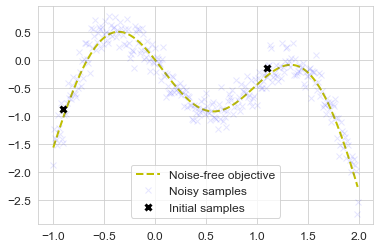

In [11]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X, 0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X, noise), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

Цель --- найти глобальный оптимум слева за возможно меньшее количество шагов.
Следующим шагом является реализация функции улучшения `expected_improvement`, определённой в уравнении (2). 

In [13]:
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample)
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
#         ei[sigma == 0.0] = 0.0

    return ei

Нам также нужна функция, которая предлагает следующую точку выборки путем вычисления местоположения функции сбора максимума
Оптимизация перезапускается `n_restarts` раз, чтобы избежать попадания в локальный оптимум.

In [15]:
def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

Now we have all components needed to run Bayesian optimization with the [algorithm](#Optimization-algorithm) outlined above. The Gaussian process in the following example is configured with a [Matérn kernel](http://scikit-learn.org/stable/modules/gaussian_process.html#matern-kernel) which is a generalization of the squared exponential kernel or RBF kernel. The known noise level is configured with the `alpha` parameter. 

Теперь у нас есть все компоненты, необходимые для выполнения байесовской оптимизации с помощью алгоритма, описанного выше. Гауссовский процесс в следующем примере сконфигурирован с ядром Matérn, которое является обобщением квадратного экспоненциального ядра или ядра RBF. Известный уровень шума конфигурируется с `альфа` параметром. 

Bayesian optimization runs for 10 iterations. In each iteration, a row with two plots is produced. The left plot shows the noise-free objective function, the surrogate function which is the GP posterior predictive mean, the 95% confidence interval of the mean and the noisy samples obtained from the objective function so far. The right plot shows the acquisition function. The vertical dashed line in both plots shows the proposed sampling point for the next iteration which corresponds to the maximum of the acquisition function.

Байесовская оптимизация выполняется в течение 10 итераций. В каждой итерации производится ряд с двумя графиками. На левом графике показана бесшумная объективная функция, суррогатная функция, которая является задним предсказательным средним GP, 95% доверительный интервал среднего и шумовые выборки, полученные до сих пор от объективной функции. На правом графике показана функция получения. Вертикальная пунктирная линия на обоих графиках показывает предлагаемую точку выборки для следующей итерации, которая соответствует максимуму функции поглощения.

In [17]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition

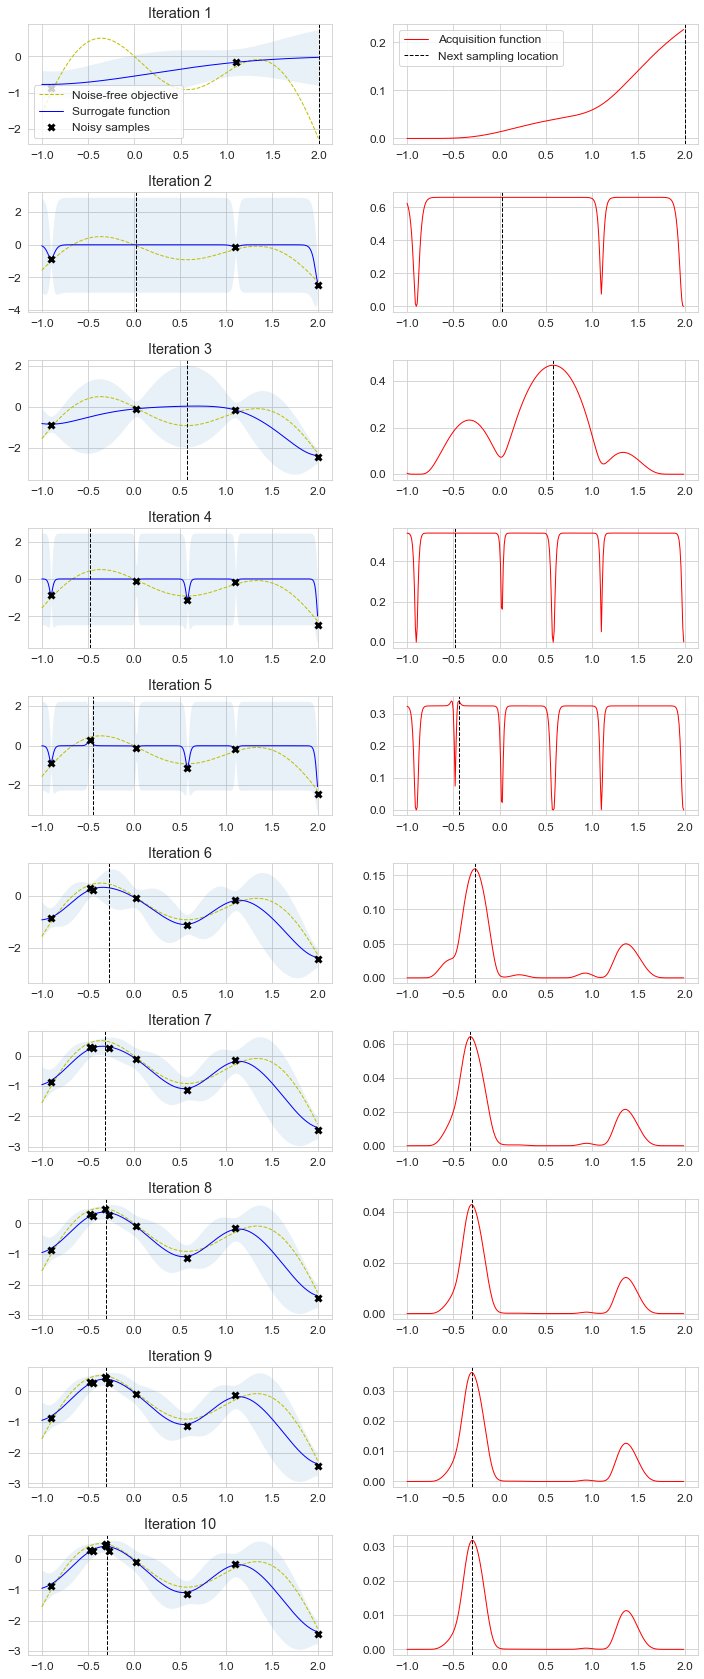

In [18]:
# Gaussian process with Matérn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

Note how the two initial samples initially drive search into the direction of the local maximum on the right side but exploration allows the algorithm to escape from that local optimum and find the global optimum on the left side. Also note how sampling point proposals often fall within regions of high uncertainty (exploration) and are not only driven by the highest surrogate function values (exploitation).

Обратите внимание на то, как два исходных образца изначально ведут поиск в направлении локального максимума справа, но поиск позволяет алгоритму выйти из этого локального оптимума и найти глобальный оптимум слева. Отметим также, что предложения по точкам выборки часто попадают в регионы с высокой неопределенностью (разведка) и обусловлены не только самыми высокими значениями суррогатной функции (эксплуатация).

A convergence plot reveals how many iterations are needed the find a maximum and if the sampling point proposals stay around that maximum i.e. converge to small proposal differences between consecutive steps.

График сходимости показывает, сколько итераций необходимо, чтобы найти максимум, и если предложения по точке выборки остаются вокруг этого максимума, т.е. сходятся в небольших расхождениях между последовательными этапами. 

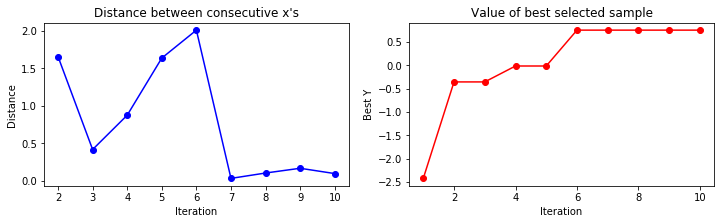

In [18]:
from bayesian_optimization_util import plot_convergence

plot_convergence(X_sample, Y_sample)

## Bayesian optimization libraries
## Байесовские библиотеки оптимизации

There are numerous Bayesian optimization libraries out there and giving a comprehensive overview is not the goal of this article. Instead, I'll pick two that I used in the past and show the minimum setup needed to get the previous example running.

Существует множество байесовских библиотек оптимизации, и предоставление полного обзора не является целью этой статьи. Вместо этого, я выберу две, которые я использовал в прошлом, и покажу минимальную установку, необходимую для запуска предыдущего примера.

### Scikit-optimize

[Scikit-optimize](https://scikit-optimize.github.io/) is a library for sequential model-based optimization that is based on [scikit-learn](http://scikit-learn.org/). It also supports Bayesian optimization using Gaussian processes. The API is designed around minimization, hence, we have to provide negative objective function values.  The results obtained here slightly differ from previous results because of non-deterministic optimization behavior and different noisy samples drawn from the objective function.

[Scikit-оптимизация] - это библиотека последовательной оптимизации на основе моделей, основанная на [scikit-learn]. Она также поддерживает байесовскую оптимизацию с использованием гауссовских процессов. API разработано на основе минимизации, поэтому мы должны предоставлять отрицательные объективные значения функций.  Полученные здесь результаты несколько отличаются от предыдущих из-за недетерминистического поведения оптимизации и различных шумных выборок, взятых из объектной функции.

In [19]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern

# Use custom kernel and estimator to match previous example
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

r = gp_minimize(lambda x: -f(np.array(x))[0], 
                bounds.tolist(),
                base_estimator=gpr,
                acq_func='EI',      # expected improvement
                xi=0.01,            # exploitation-exploration trade-off
                n_calls=10,         # number of iterations
                n_random_starts=0,  # initial samples are provided
                x0=X_init.tolist(), # initial samples
                y0=-Y_init.ravel())

# Fit GP model to samples for plotting results
gpr.fit(r.x_iters, -r.func_vals)

# Plot the fitted model and the noisy samples
plot_approximation(gpr, X, Y, r.x_iters, -r.func_vals, show_legend=True)

ModuleNotFoundError: No module named 'skopt'

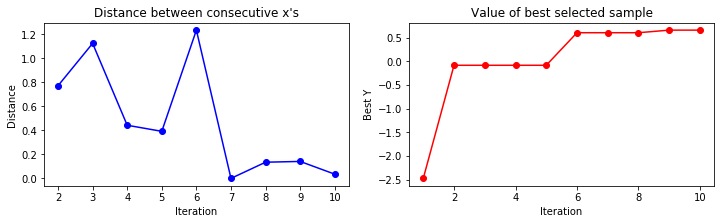

In [22]:
plot_convergence(np.array(r.x_iters), -r.func_vals)

## GPyOpt

[GPyOpt](http://sheffieldml.github.io/GPyOpt/) is a Bayesian optimization library based on [GPy](https://sheffieldml.github.io/GPy/). The abstraction level of the API is comparable to that of scikit-optimize. The `BayesianOptimization` API provides a `maximize` parameter to configure whether the objective function shall be maximized or minimized (default). In version 1.2.1, this seems to be ignored when providing initial samples, so we have to negate their target values manually in the following example. Also, the built-in `plot_acquisition` and `plot_convergence` methods display the minimization result in any case. Again, the results obtained here slightly differ from previous results because of non-deterministic optimization behavior and different noisy samples drawn from the objective function. 

In [19]:
import GPy
import GPyOpt

from GPyOpt.methods import BayesianOptimization

kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
bds = [{'name': 'X', 'type': 'continuous', 'domain': bounds.ravel()}]

optimizer = BayesianOptimization(f=f, 
                                 domain=bds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 X=X_init,
                                 Y=-Y_init,
                                 noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True)

optimizer.run_optimization(max_iter=10)
optimizer.plot_acquisition()

ModuleNotFoundError: No module named 'GPy'

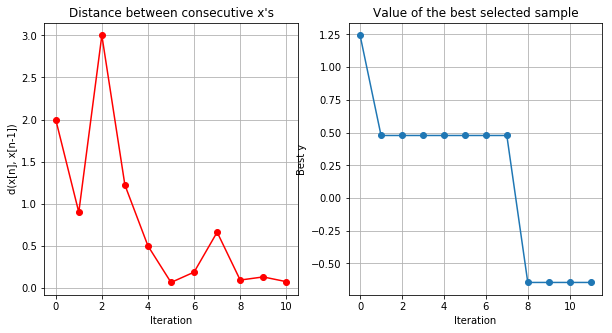

In [26]:
optimizer.plot_convergence()

## Application

This section demonstrates how to optimize the hyperparameters of an `XGBRegressor` with GPyOpt and how Bayesian optimization performance compares to random search. `XGBRegressor` is part of [XGBoost](https://xgboost.readthedocs.io/), a flexible and scalable gradient boosting library. `XGBRegressor` implements the scikit-learn estimator API and can be applied to regression problems. Regression is performed on a small [toy dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes) that is part of scikit-learn.

In [7]:
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from scipy.stats import uniform
from xgboost import XGBRegressor

# Load the diabetes dataset (for regression)
X, Y = datasets.load_diabetes(return_X_y=True)

# Instantiate an XGBRegressor with default hyperparameter settings
xgb = XGBRegressor()

# and compute a baseline to beat with hyperparameter optimization 
baseline = cross_val_score(xgb, X, Y, scoring='neg_mean_squared_error').mean()

### Hyperparameter tuning with random search

For hyperparameter tuning with random search, we use `RandomSearchCV` of scikit-learn and compute a cross-validation score for each randomly selected point in hyperparameter space. Results will be discussed below.

In [8]:
# Hyperparameters to tune and their ranges
param_dist = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10)}

rs = RandomizedSearchCV(xgb, param_distributions=param_dist, 
                        scoring='neg_mean_squared_error', n_iter=25)

# Run random search for 25 iterations
rs.fit(X, Y);

### Hyperparameter tuning with Bayesian optimization

To tune hyperparameters with Bayesian optimization we implement an objective function `cv_score` that takes hyperparameters as input and returns a cross-validation score. Here, we assume that cross-validation at a given point in hyperparameter space is deterministic and therefore set the `exact_feval` parameter of `BayesianOptimization` to `True`. Depending on model fitting and cross-validation details this might not be the case but we ignore that here.

In [15]:
bds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
        {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 300)},
        {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}]

# Optimization objective 
def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
                XGBRegressor(learning_rate=parameters[0],
                              gamma=int(parameters[1]),
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              min_child_weight = parameters[4]), 
                X, Y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=True)

# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=20)

### Results

On average, Bayesian optimization finds a better optimium in a smaller number of steps than random search and beats the baseline in almost every run. This trend becomes even more prominent in higher-dimensional search spaces. Here, the search space is 5-dimensional which is rather low to substantially profit from Bayesian optimization. One advantage of random search is that it is trivial to parallelize. Parallelization of Bayesian optimization is much harder and subject to research (see \[4\], for example).

Baseline neg. MSE = -3498.95
Random search neg. MSE = -3678.77
Bayesian optimization neg. MSE = -3185.50


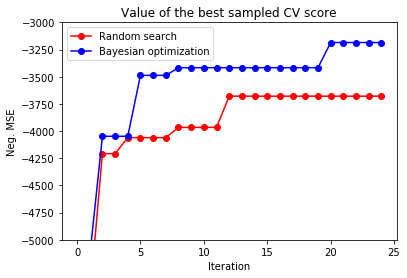

In [16]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

print(f'Baseline neg. MSE = {baseline:.2f}')
print(f'Random search neg. MSE = {y_rs[-1]:.2f}')
print(f'Bayesian optimization neg. MSE = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.ylim(-5000, -3000)
plt.title('Value of the best sampled CV score');
plt.legend();

## References

\[1\] Eric Brochu, Vlad M. Cora, Nando de Freitas, [A Tutorial on Bayesian Optimization of Expensive Cost Functions](https://arxiv.org/abs/1012.2599). \
\[2\] Jonas Mockus, [Application of Bayesian approach to numerical methods of global and stochastic optimization](https://link.springer.com/article/10.1007/BF01099263). \
\[3\] Donald R. JonesMatthias SchonlauWilliam J. Welch, [Efficient Global Optimization of Expensive Black-Box Functions](https://link.springer.com/article/10.1023/A:1008306431147). \
\[4\] Jialei Wang, Scott C. Clark, Eric Liu, Peter I. Frazier, [Parallel Bayesian Global Optimization of Expensive Functions](https://arxiv.org/abs/1602.05149).